In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import optimize
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from PIL import Image 
import numpy.polynomial.polynomial as poly
from IPython.display import clear_output


%matplotlib inline


In [2]:
cd /Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/CutImages

/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/CutImages


In [3]:
DataSet = os.listdir()
DataSet = [x for x in DataSet if x != '.DS_Store']
DataSet

['BaSmall', 'CaSmall', 'NaSmall']

In [4]:
DataPath = '/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/CutImages'

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [7]:
eCoeff = 0.01160
eOffset= 1970
AreaFull = dict()
AreaCUT = dict()
PairsM = dict()
PairsA = dict()
AreaCUT2 = dict() 
PairsM2 = dict()
Bleached = dict()
INFO1 = dict()
INFO2 = dict()

LIFETIME= dict()
INTENSITY= dict()
AREA= dict()
AREAPRE=dict()
AREASS=dict()
CHIR= dict()
MEAND= dict()
PPairs = []
for z in range(0,len(DataSet)):
    FoldPath = DataPath+'/'+DataSet[z]
    Folders = os.listdir(FoldPath)
    Folders = [x for x in Folders if x != '.DS_Store']
    
    AreaH=[]        # kill this ?
    AreaHH=[]       # kill this ?
    SpotAreaH = []  # kill this ?
    SpotAreaHH = [] # kill this ?
    SpotAreaHH2 = []# kill this ?
    PairsMade2 = [] # kill this ?
    Bleach = []     # kill this ?
    MASTERTau = []
    MASTERItn = []
    MASTERarea=[]
    MASTERchiRa=[]
    MASTERmeanD=[]
    MASTERareaSS=[]
    MASTERareaPre=[]
    
    PairsMade = []
    Shape = 221
    xvs = np.arange(0,Shape)
    ##Means = []# kill this ?
    #Devs  = []# kill this ?
    neighborhood_size = 9
    Row = int(4) # define the area to take around the spots
    Col = int(4) # define the area to take around the spots
    for w in range(0,len(Folders)):
        folder = FoldPath+'/'+Folders[w]
        files = os.listdir(folder)
        files = [x for x in files if x != '.DS_Store']
        DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
        Datatot = DataSub
        fitts = []
        AllPairs =[]
        SpotInfo2 = []

        ImageB = []
        MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
        eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
        eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
        for x in range(250,300):
            Images = np.array(Image.open(folder+'/'+files[x]))
            Images = eCoeffM*(Images - eOffsetM)
            #Mfit = np.zeros(len(xvs)) # kill this ?
            ImageFit = []
            for y in range(0,Shape):
                coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
                ffit  = poly.polyval(xvs, coefs)
                ImageFit.append(ffit)
            MeanFit+=np.array(ImageFit)
        MeanFit = MeanFit/50


        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            DataSub += Images


        data = DataSub

        #Means.append(np.mean(data)) # kill this ?
        #Devs.append(np.std(data))   # kill this ?

        threshold = np.mean(data)+3*np.std(data)

        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        Pairs = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            x.append(x_center)
            y_center = (dy.start + dy.stop - 1)/2    
            y.append(y_center)
            Pairs.append((x_center,y_center))
        for item in Pairs:
            if item not in AllPairs:
                AllPairs.append(item) 


        Images = None
        ImageB = None
        #data   = None
        Slices = None
        labeled= None
        num_objects=None

        ############################################################## 
        Xc=[]
        Yc=[]
        for qw in range(0,len(AllPairs)):
            XX = AllPairs[qw][0]
            YY = AllPairs[qw][1]
            if XX>10 and XX<210 and YY>10 and YY<210:
                Xc.append(XX)
                Yc.append(YY)
        #try:
            #Xc=[]
            #Yc=[]
            #for qw in range(0,len(AllPairs)):
                #XX = AllPairs[qw][0]
                #YY = AllPairs[qw][0]
                #if XX>10 and XX<210 and YY>10 and YY<210:
                    #Xc.append(XX)
                    #Yc.append(YY)
        #except ValueError:
            #break
            #Xc=0
            #Yc=0
            #AllPairs=0

        for q in range(0,len(files)):
            Images = (np.array(Image.open(folder+'/'+files[q])))# - MeanFit)
            Images = eCoeffM*(Images - eOffsetM) - MeanFit
            Images[Images < 0] = 0 

            SpotInfoHolder = []

            for we in range(0,len(Xc)):
                Xindex = int(Xc[we])
                Yindex = int(Yc[we])

                spot1 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot2 = np.array(Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1])
                spot = spot1[2:7,2:7]
                SpotRemove = np.zeros(5**2).reshape((5,5))
                spot2[2:7,2:7]=SpotRemove
                spotB = spot2

                ATot = spot.sum()
                ATotB = spot2.sum()
                SpotInfo2.append([z,w,Xindex,Yindex,ATot,ATotB])

    ########################################################################################  

            clear_output()
            print('Finding all areas in dataset'+' '+str(z)) 
            print('Finding all areas in folder'+' '+str(w)) 
            print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))

        Par = len(AllPairs)
        AVG = 5
        Mnumb = 5
        PairsMade=[]
        Tau = []
        Signal = []
        for x in range(0,Par):
            HoldArea = np.array(SpotInfo2[x::Par])[:,4]
            HoldAreaB = np.array(SpotInfo2[x::Par])[:,5]*(25/56)
            aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), AVG))/AVG
            aaB = np.add.reduceat(HoldAreaB, np.arange(0, len(HoldAreaB), AVG))/AVG
            vals =np.arange(0,len(aa))

            coefs = poly.polyfit(vals,aaB, 3)
            ffit  = poly.polyval(vals, coefs)
            Sig = np.array(aa-ffit)

            meanI = np.mean(Sig[:Mnumb])
            sigmaI = np.std(Sig[:Mnumb])
            meanE = np.mean(Sig[-Mnumb:])
            sigmaE = np.std(Sig[-Mnumb:])
            meanM = np.mean(Sig)
            T = len(Sig)
            tau = ((meanM - meanE)/(meanI -meanE))*T
            Tau.append(tau)
            Signal.append(Sig)

        Tau2 = []
        Offset = 5
        for x in range(0,Par):
            TauH = Tau[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau2.append(TauH)

        Tau3 = []
        Offset = 3
        for x in range(0,Par):
            TauH = Tau2[x]
            for q in range(0,50):
                meanI = np.mean(running_mean(Signal[x],4)[:int(TauH)-Offset])
                meanE = np.mean(running_mean(Signal[x],4)[int(TauH)+Offset:])
                T = len(Signal[x])
                meanM = np.mean(Signal[x])
                tau = ((meanM - meanE)/(meanI -meanE))*T 
                if tau != tau:
                    tau = -10
                TauH = tau
            Tau3.append(TauH)
            

        #data = []
        #PairsMade = []
        #chiF = []
        #chiB = []
        #chiFIT=[]
        chiRa = []
        meanDif = []
        #Dtau = []
        areaS=[]
        areaSS=[]
        areaPre=[]
        ITEN=[]
        Offset =3
        for x in range(0,Par):
            TauH   = Tau3[x]
            Data = running_mean(Signal[x],4)
            DataLeft  = Data[:int(TauH)-Offset]
            DataRight = Data[int(TauH)+Offset:]
            sigma = np.std(Data)
            mean  = np.mean(Data)
            meanI  = np.mean(DataLeft)
            sigmaI = np.std(DataLeft)
            meanE  = np.mean(DataRight)
            sigmaE = np.std(DataRight)
            Inten  = Signal[x][:int(TauH)]
            Intensity  = np.sum(Inten)/len(Inten)
            chiHIGH = np.sum((DataLeft - np.mean(DataLeft))**2)
            chiLOW = np.sum((DataRight - np.mean(DataRight))**2)
            val = np.arange(0,len(Data),1)
            fit=np.polyfit(val,Data,1)    
            chiFit  = np.sum((np.polyval(fit, val) - Data) ** 2)
            ###dtau = TauH*np.sqrt(((sigma-sigmaE)/(mean-meanE))**2+((sigmaI-sigmaE)/(meanI-meanE))**2)
            #data.append([Signal[x],TauH,Intensity])
            #PairsMade.append(AllPairs[x])
            #chiF.append(chiHIGH)
            #chiB.append(chiLOW)
            #chiFIT.append(chiFit)
            ITEN.append(Intensity)
            chiRa.append((chiLOW+chiHIGH)/ chiFit)
            meanDif.append(meanI-meanE)
            ###Dtau.append(dtau)
            areaS.append(Signal[x])
            areaSS.append(Data)
            areaPre.append(DataLeft)
        MASTERTau.append(Tau3)
        MASTERItn.append(ITEN)
        MASTERarea.append(areaS)
        MASTERareaSS.append(areaSS)
        MASTERareaPre.append(areaPre)

        MASTERchiRa.append(chiRa)
        MASTERmeanD.append(meanDif)
        
          
    LIFETIME[z] = [item for sublist in MASTERTau for item in sublist]
    INTENSITY[z]= [item for sublist in MASTERItn for item in sublist]
    AREA[z]     = [item for sublist in MASTERarea for item in sublist]
    AREAPRE[z]     = [item for sublist in MASTERareaPre for item in sublist]
    AREASS[z]     = [item for sublist in MASTERareaSS for item in sublist]

    CHIR[z]     = [item for sublist in MASTERchiRa for item in sublist]
    MEAND[z]    = [item for sublist in MASTERmeanD for item in sublist]

    #AreaFull[z]  = [item for sublist in AreaHH for item in sublist]
    #AreaCUT[z]   = [item for sublist in SpotAreaHH for item in sublist]
    #PairsM[z]    = [item for sublist in PairsMade for item in sublist]
    #PairsA[z]    = [item for sublist in PPairs for item in sublist]
    #AreaCUT2[z]  = [item for sublist in SpotAreaHH2 for item in sublist]
    #PairsM2[z]   = [item for sublist in PairsMade2 for item in sublist]
    #Bleached[z]  = Bleach

Finding all areas in dataset 2
Finding all areas in folder 5
On file 300 of 300


In [8]:
for x in range(0,len(DataSet)):
    print(DataSet[x]+' '+' pairs = ',len(LIFETIME[x]))

BaSmall  pairs =  1213
CaSmall  pairs =  192
NaSmall  pairs =  931


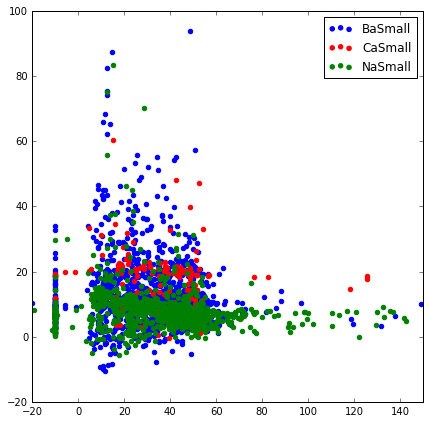

In [9]:
plt.figure(figsize=(7,7))
plt.scatter(LIFETIME[0],INTENSITY[0],color='b',label=DataSet[0])
plt.scatter(LIFETIME[1],INTENSITY[1],color='r',label=DataSet[1])
plt.scatter(LIFETIME[2],INTENSITY[2],color='g',label=DataSet[2])
#fitba=np.polyfit(LIFETIME[0],INTENSITY[0],1)
#fitca=np.polyfit(LIFETIME[1],INTENSITY[1],1)
#fitna=np.polyfit(LIFETIME[2],INTENSITY[2],1)
vars=np.arange(0,100,1)
#plt.plot(vars,fitba[1]+vars*fitba[0],color='b')
#plt.plot(vars,fitca[1]+vars*fitca[0],color='r')
#plt.plot(vars,fitna[1]+vars*fitna[0],color='g')
#plt.plot()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-20,150)
plt.ylim(-20,100)
plt.show()

In [11]:
itensity=dict()
lifetime=dict()
for x in range(0,len(DataSet)):
    LT=[]
    IT=[]
    for z in range(0,len(LIFETIME[x])):
        if MEAND[x][z]>20:#if LIFETIME[x][z]>0 and INTENSITY[x][z]>0 and INTENSITY[x][z]<60:
            LT.append(LIFETIME[x][z])
            IT.append(INTENSITY[x][z])
    lifetime[x]=LT# = [item for sublist in LT for item in sublist]
    itensity[x]=IT# = [item for sublist in IT for item in sublist]
len(lifetime[0])

122

Ba tau =  90.5311 ms
Ca tau =  -120.2707 ms


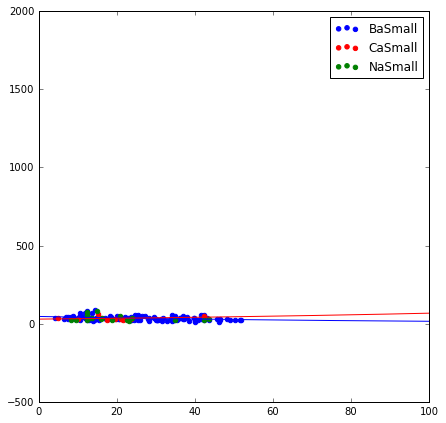

In [13]:
plt.figure(figsize=(7,7))

plt.scatter(lifetime[0],itensity[0],color='b',label=DataSet[0])
plt.scatter(lifetime[1],itensity[1],color='r',label=DataSet[1])
plt.scatter(lifetime[2],itensity[2],color='g',label=DataSet[2])
fitba,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[0],  itensity[0],  p0=(1, 0.1))
fitca,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[1],  itensity[1],  p0=(1, 0.1))
#fitna,two = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  lifetime[2],  itensity[2],  p0=(1, 0.1))
vars=np.arange(0,500,1)
plt.plot(vars,fitba[0]*np.exp(fitba[1]*vars),color='b')
plt.plot(vars,fitca[0]*np.exp(fitca[1]*vars),color='r')
#plt.plot(vars,fitna[0]*np.exp(fitna[1]*vars),color='r')

#plt.plot(vars,fitba[1]+vars*fitba[0],color='b')
#plt.plot(vars,fitca[1]+vars*fitca[0],color='r')
#plt.plot(vars,fitna[1]+vars*fitna[0],color='g')
plt.plot()
plt.legend()
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,100)
#plt.ylim(0,100)
print('Ba tau = ',"%.4f"%(-1/fitba[1]),"ms")
print('Ca tau = ',"%.4f"%(-1/fitca[1]),"ms")
#print('Na m and b = ',"%.4f"%fitna[0],"%.4f"%fitna[1])
plt.show()

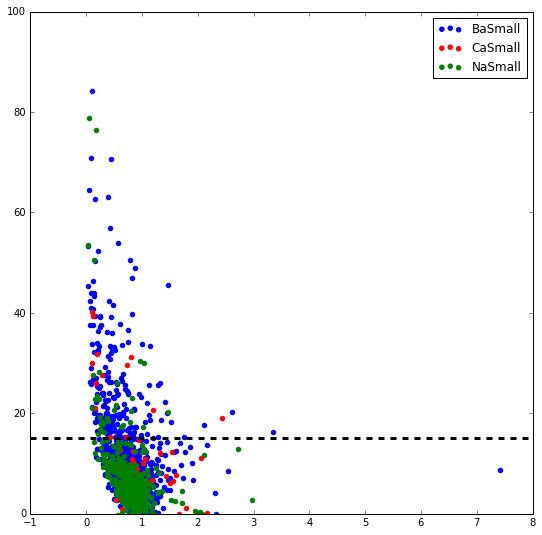

In [14]:
plt.figure(figsize=(9,9))
plt.scatter(CHIR[0],MEAND[0],color='b',label=DataSet[0])
plt.scatter(CHIR[1],MEAND[1],color='r',label=DataSet[1])
plt.scatter(CHIR[2],MEAND[2],color='g',label=DataSet[2])
plt.axhline(15,linewidth=3,linestyle='--',color='k')
#plt.axvline(0.5)
plt.legend()
#plt.xlim(.3,2)
plt.ylim(0,100)
plt.show()

In [9]:
len(INTENSITY[0])

2503

In [34]:
aa = [item for sublist in AREA[0] for item in sublist]
len(aa)

248997

In [15]:
AreaPass=dict()
for x in range(0,len(DataSet)):
    AP=[]
    for z in range(0,len(MEAND[x])):
        if MEAND[x][z]>15:# and CHIR[x][z]<0.5:
            #AP.append(running_mean(AREAPRE[x][z],4))
            AP.append(AREAPRE[x][z])
            #AP.append(AREASS[x][z])
            #AP.append(INTENSITY[x][z])
    AreaPass[x] = [item for sublist in AP for item in sublist]
len(AreaPass[0])

5046

In [16]:
len(AreaPass[2])

619

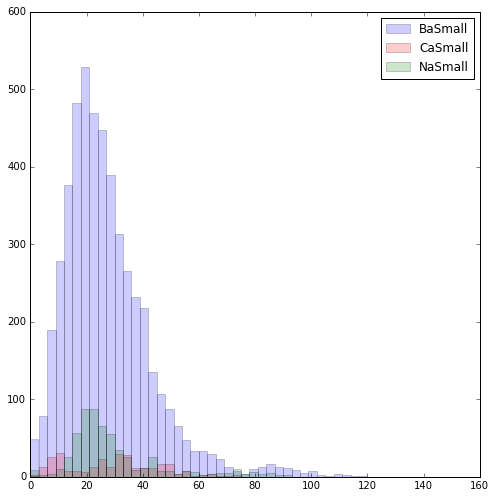

In [17]:
'''area cut at 4e3'''
#BaCu5 = np.array(AreaPass[0])
#NaCu5 = np.array(AreaPass[2])
#CaCu5 = np.array(AreaPass[1])
plt.figure(figsize=(7,7))
num =3
W0 = np.ones(len(AreaPass[0]))
W1 = np.ones(len(AreaPass[1]))
W2 = np.ones(len(AreaPass[2]))

plt.hist(AreaPass[0],label=DataSet[0],alpha=0.2,color='b',bins=np.arange(0,150,num))
plt.hist(AreaPass[1],label=DataSet[1],alpha=0.2,color='r',bins=np.arange(0,150,num))
plt.hist(AreaPass[2],label=DataSet[2],alpha=0.2,color='g',bins=np.arange(0,150,num))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

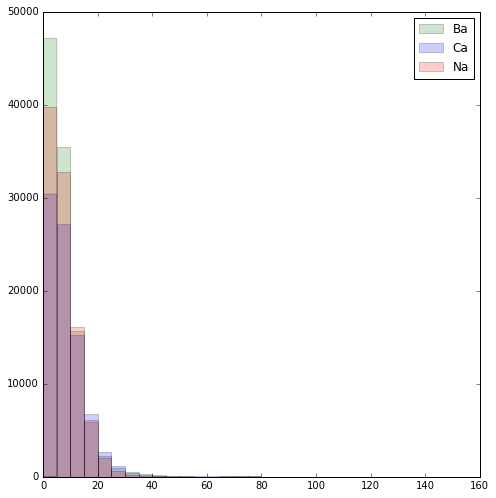

In [45]:
Ba = [item for sublist in AREA[0] for item in sublist]
Ca = [item for sublist in AREA[1] for item in sublist]
Na = [item for sublist in AREA[2] for item in sublist]
Ba=np.array(Ba)
Ca=np.array(Ca)
Na=np.array(Na)
plt.figure(figsize=(7,7))
plt.hist(Ba,label=DataSet[0],alpha=0.2,color='g',bins=np.arange(0,150,5))
plt.hist(Ca,label=DataSet[1],alpha=0.2,color='b',bins=np.arange(0,150,5))
plt.hist(Na,label=DataSet[2],alpha=0.2,color='r',bins=np.arange(0,150,5))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
#plt.axvline(70,linewidth=3,color='k')
#plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

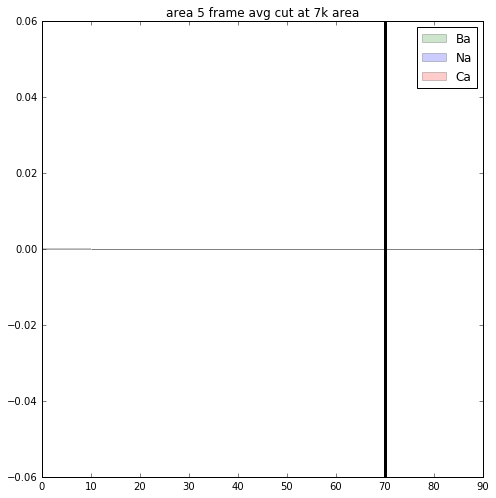

In [51]:
'''area cut at 4e3'''
BaCu5 = np.array(AreaCUT[0])
NaCu5 = np.array(AreaCUT[2])
CaCu5 = np.array(AreaCUT[1])
plt.figure(figsize=(7,7))
plt.hist(BaCu5,label='Ba',alpha=0.2,color='g',bins=np.arange(0,500,10))
plt.hist(NaCu5,label='Na',alpha=0.2,color='b',bins=np.arange(0,500,10))
plt.hist(CaCu5,label='Ca',alpha=0.2,color='r',bins=np.arange(0,500,10))
#plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
plt.axvline(70,linewidth=3,color='k')
plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

In [80]:
np.arange(0,500,15)

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375,
       390, 405, 420, 435, 450, 465, 480, 495])

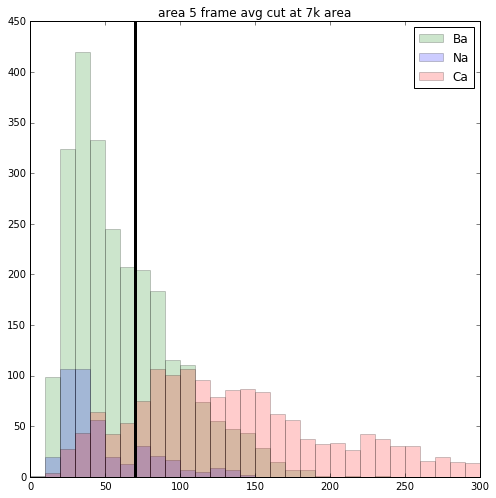

In [93]:
'''area cut at 4e3'''
BaCu5 = np.array(AreaCUT2[0])
NaCu5 = np.array(AreaCUT2[2])
CaCu5 = np.array(AreaCUT2[1])
plt.figure(figsize=(7,7))
plt.hist(BaCu5,label='Ba',alpha=0.2,color='g',bins=np.arange(0,500,10))
plt.hist(NaCu5,label='Na',alpha=0.2,color='b',bins=np.arange(0,500,10))
plt.hist(CaCu5,label='Ca',alpha=0.2,color='r',bins=np.arange(0,500,10))
plt.xlim(0,300)
#plt.ylim(0,25)
plt.legend()
plt.axvline(70,linewidth=3,color='k')
plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

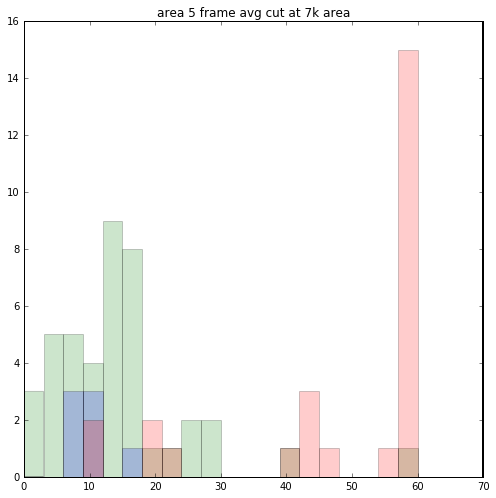

In [92]:
'''area cut at 4e3'''
BaCu5 = np.array(Bleached[0])
NaCu5 = np.array(Bleached[2])
CaCu5 = np.array(Bleached[1])
plt.figure(figsize=(7,7))
plt.hist(BaCu5,label='Ba',alpha=0.2,color='g',bins=np.arange(0,70,3))
plt.hist(NaCu5,label='Na',alpha=0.2,color='b',bins=np.arange(0,70,3))
plt.hist(CaCu5,label='Ca',alpha=0.2,color='r',bins=np.arange(0,70,3))
#plt.xlim(0,300)
#plt.ylim(0,25)
#plt.legend()
plt.axvline(70,linewidth=3,color='k')
plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

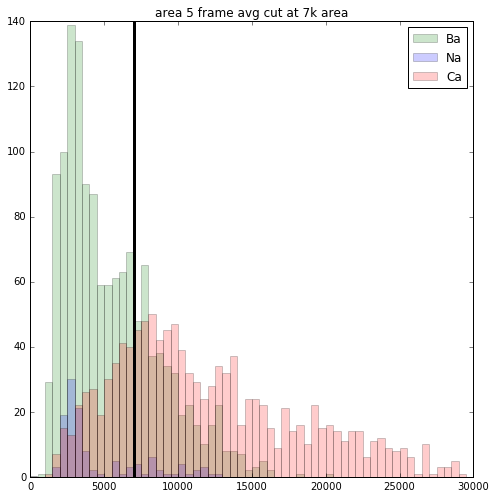

In [37]:
'''area cut at 4e3'''
BaCu5 = np.array(AreaCUT[0])
NaCu5 = np.array(AreaCUT[2])
CaCu5 = np.array(AreaCUT[1])
bins=50
plt.figure(figsize=(7,7))
plt.hist(BaCu5[BaCu5 <30e3],label='Ba',alpha=0.2,color='g',bins=np.arange(0,30000,500))
plt.hist(NaCu5[NaCu5 <30e3],label='Na',alpha=0.2,color='b',bins=np.arange(0,30000,500))
plt.hist(CaCu5[CaCu5 <30e3],label='Ca',alpha=0.2,color='r',bins=np.arange(0,30000,500))
plt.xlim(0,3e4)
#plt.ylim(0,25)
plt.legend()
plt.axvline(7000,linewidth=3,color='k')
plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

In [179]:
#CaArea = [item for sublist in AreaH for item in sublist]
#CaArea5 = [item for sublist in AreaHH for item in sublist]
#CaCut = [item for sublist in SpotAreaH for item in sublist]
#CaCut5 = [item for sublist in SpotAreaHH for item in sublist]

#BaArea = [item for sublist in AreaH for item in sublist]
#BaArea5 = [item for sublist in AreaHH for item in sublist]
#BaCut = [item for sublist in SpotAreaH for item in sublist]
#BaCut5 = [item for sublist in SpotAreaHH for item in sublist]

#NaArea = [item for sublist in AreaH for item in sublist]
#NaArea5 = [item for sublist in AreaHH for item in sublist]
#NaCut = [item for sublist in SpotAreaH for item in sublist]
#NaCut5 = [item for sublist in SpotAreaHH for item in sublist]

In [ ]:
'''cd /Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat
np.savetxt('NaArea',NaArea5,delimiter=',')
np.savetxt('NaArea5',NaArea5,delimiter=',')
np.savetxt('BaArea',NaArea5,delimiter=',')
np.savetxt('BaArea5',NaArea5,delimiter=',')
np.savetxt('CaArea',NaArea5,delimiter=',')
np.savetxt('CaArea5',NaArea5,delimiter=',')'''

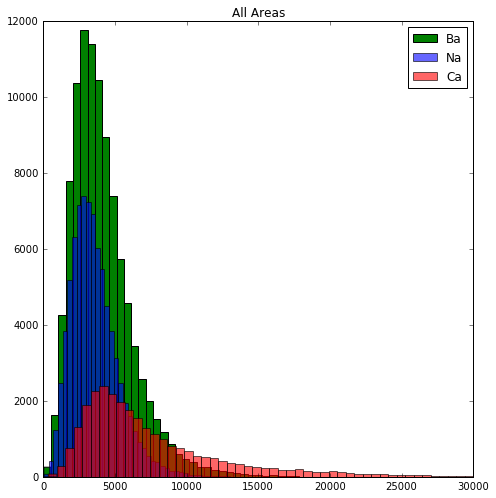

In [71]:
BaArea = np.array(BaArea)
NaArea = np.array(NaArea)
CaArea = np.array(CaArea)
bins = 50
plt.figure(figsize=(7,7))
plt.hist(BaArea[BaArea <30e3],bins,label='Ba',color='g')
plt.hist(NaArea[NaArea <30e3],bins,label='Na',alpha=0.6)
plt.hist(CaArea[CaArea <30e3],bins,label='Ca',alpha=0.6, color='r')
plt.xlim(0,3e4)
#plt.ylim(0,500)
plt.legend()
plt.title('All Areas')
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'AllAreas')
plt.show()

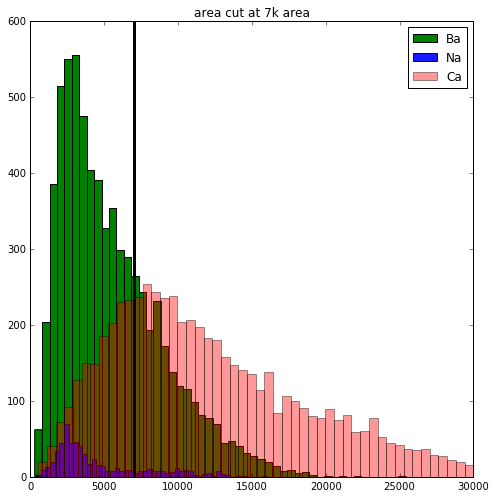

In [180]:
'''area cut at 4e3'''
BaCu = np.array(BaCut)
NaCu = np.array(NaCut)
CaCu = np.array(CaCut)
bins=50
plt.figure(figsize=(7,7))
plt.hist(BaCu[BaCu <30e3],bins,label='Ba',color='g')
plt.hist(NaCu[NaCu <30e3],bins,label='Na',alpha=0.9,color='b')
plt.hist(CaCu[CaCu <30e3],bins,label='Ca',alpha=0.4,color='r')
plt.xlim(0,3e4)
#plt.ylim(0,500)
plt.legend()
plt.axvline(7000,linewidth=3,color='k')
plt.title("area cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'AllAreas-CutAt7k')
plt.show()

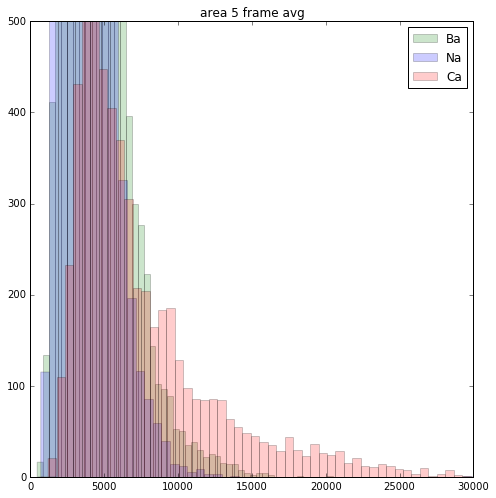

In [190]:
BaArea5 = np.array(BaArea5)
NaArea5 = np.array(NaArea5)
CaArea5 = np.array(CaArea5)
bins=50
plt.figure(figsize=(7,7))
plt.hist(BaArea5[BaArea5 <30e3],bins,label='Ba',color='g',alpha = 0.2)
plt.hist(NaArea5[NaArea5 <30e3],bins,label='Na',alpha=0.2)
plt.hist(CaArea5[CaArea5 <30e3],bins,label='Ca',alpha=0.2,color='r')
plt.xlim(0,3e4)

plt.ylim(0,500)
plt.legend()
plt.title("area 5 frame avg")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-5frameAVG')
plt.show()

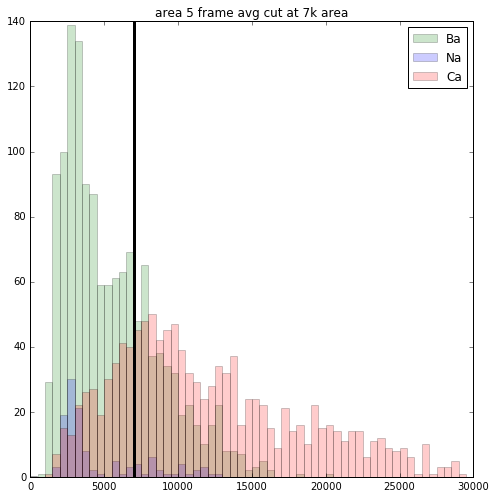

In [198]:
'''area cut at 4e3'''
BaCu5 = np.array(BaCut5)
NaCu5 = np.array(NaCut5)
CaCu5 = np.array(CaCut5)
bins=50
plt.figure(figsize=(7,7))
plt.hist(BaCu5[BaCu5 <30e3],label='Ba',alpha=0.2,color='g',bins=np.arange(0,30000,500))
plt.hist(NaCu5[NaCu5 <30e3],label='Na',alpha=0.2,color='b',bins=np.arange(0,30000,500))
plt.hist(CaCu5[CaCu5 <30e3],label='Ca',alpha=0.2,color='r',bins=np.arange(0,30000,500))
plt.xlim(0,3e4)
#plt.ylim(0,25)
plt.legend()
plt.axvline(7000,linewidth=3,color='k')
plt.title("area 5 frame avg cut at 7k area")
plt.tight_layout()
#plt.savefig('/Users/austinmcdonald/Desktop/SingleMolecule-selected-092817/Hist-dat/'+'Areas-CutAt7k-5frameAVG')
plt.show()

In [191]:
sum(BaCu5[BaCu5 <30e3])/sum(CaCu5[CaCu5 <50e3])

0.51297936199937844

In [ ]:
'''        for x in range(0,len(PairsMade)):
            thold = 70
            Cut2 = SpotAreaHH[x]
            CutP = PairsMade[x]
            High = []
            Low = []
            for x in range(1,len(Cut2)):
                if Cut2[x] >= thold:
                    High.append(x)
                elif Cut2[x] < thold:
                    Low.append(x)
            pos=[]
            for x in range(0,len(High)):
                if all(i >= High[x] for i in Low):# all bad must be bigger than good!
                    pos.append(1)
                else:
                    pos.append(0)
            if pos.count(1)>=1:
                SpotAreaHH2.append(Cut2)
                PairsMade2.append(CutP)  
                Bleach.append(pos.count(1))'''



In [ ]:
AreaH=[]
AreaHH=[]
SpotAreaH = []
SpotAreaHH = []
Shape = 221
xvs = np.arange(0,Shape)
Means = []
Devs  = []
neighborhood_size = 5
Row = int(2) # define the area to take around the spots
Col = int(2) # define the area to take around the spots
for w in range(0,len(Folders)):
    folder = FoldPath+'/'+Folders[w]
    files = os.listdir(folder)
    DataSub = np.zeros(Shape**2).reshape((Shape,Shape))
    Datatot = DataSub
    fitts = []
    AllPairs =[]
    SpotInfo2 = []

    ImageB = []
    MeanFit = np.zeros(Shape**2).reshape((Shape,Shape))
    for x in range(250,300):
        Images = np.array(Image.open(folder+'/'+files[x]))
        #Mfit = np.zeros(len(xvs))
        ImageFit = []
        for y in range(0,Shape):
            coefs = poly.polyfit(xvs,Images[y], 2) # fits 11th order poly 
            ffit  = poly.polyval(xvs, coefs)
            ImageFit.append(ffit)
        MeanFit+=np.array(ImageFit)
    MeanFit = MeanFit/50
            
        
    for q in range(0,len(files)):
        Images = (np.array(Image.open(folder+'/'+files[q])) - MeanFit)
        DataSub += Images


    data = DataSub
    
    Means.append(np.mean(data))
    Devs.append(np.std(data))
    
    threshold = np.mean(data)+6*np.std(data)

    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    Pairs = []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
        Pairs.append((x_center,y_center))
    for item in Pairs:
        if item not in AllPairs:
            AllPairs.append(item) 

    clear_output()
    print('Finding AllPairs')
    print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))   
    Images = None
    ImageB = None
    data   = None
    Slices = None
    labeled= None
    num_objects=None

    ############################################################## 

    Xc,Yc = zip(*AllPairs)

    for q in range(0,len(files)):
        Images = (np.array(Image.open(folder+'/'+files[q])) - MeanFit)
        Images[Images < 0] = 0 

        SpotInfoHolder = []

        for w in range(0,len(Xc)):
            Xindex = int(Xc[w])
            Yindex = int(Yc[w])
            spot = Images[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1]
            ATot = spot.sum()
            SpotInfo2.append([q,Xindex,Yindex,ATot])

    ##############################################################  

        clear_output()
        print('Finding all areas') 
        print('On file'+' '+str(q+1)+' '+'of'+' '+str(len(files)))
        
    Par = len(AllPairs)
    AreaCut = 7e3

    for x in range(0,Par):
        HoldArea = np.array(SpotInfo2[x::Par])[:,3]
        aa = np.add.reduceat(HoldArea, np.arange(0, len(HoldArea), 5))/5
        AreaH.append(HoldArea)
        AreaHH.append(aa)
        
        aboveCut = len([i for i in aa if i > AreaCut])
        gd = np.gradient(aa)
        grad = abs(gd[5:len(gd)-5])
        #if aboveCut > 5 :
        if max(grad)>2e3 and aboveCut > 10:
            SpotAreaH.append(HoldArea)
            SpotAreaHH.append(aa)
            #PairsMade.append(AllPairs[x])
